## Load the Dataset

In [1]:
from lib.load import extract_data, load_benchmark_corpus


extract_data()
benchmark, corpus = load_benchmark_corpus()

In [2]:
import re

import numpy as np
from langchain_core.documents import Document
from sentence_transformers import SentenceTransformer
from transformers import BitsAndBytesConfig

from lib.util import cleanup


SENTENCE_SPLIT = re.compile(r'\n+')

def create_documents(
    texts: list[str],
    metadatas: list[dict],
    model_path: str="Qwen/Qwen3-Embedding-8B",
    pad: int=2,
    max_span: int=1000,
):
    model = SentenceTransformer(
        model_path,
        model_kwargs={"quantization_config": BitsAndBytesConfig(load_in_8bit=True)}
    )
    documents = []
    for text, metadata in zip(texts, metadatas):
        chunks = chunk_text(model, text, pad=pad, max_span=max_span)
        # transform chunks into documents
        for start, end in chunks:
            chunk_metadata = dict(metadata)
            chunk_metadata['start_index'] = start
            documents.append(Document(
                page_content=text[start:end],
                metadata=chunk_metadata,
            ))
    del model
    cleanup()
    return documents
        
def chunk_text(
    model,
    text: str,
    pad: int=2,
    max_span: int=1000,
):
    # preprocess setences
    spans = split_to_spans(SENTENCE_SPLIT, text)
    windowed_spans = window_spans(spans, pad=pad)
    sentence_blocks = [text[start:end] for start, end in windowed_spans]
    # generate setence embeddings
    embeddings = model.encode(sentence_blocks, show_progress_bar=True)
    cleanup()
    # split chunks
    distances = pairwise_cosine_distances(embeddings)
    chunk_spans = split_recursive(spans, distances, max_span)
    return chunk_spans

def split_to_spans(regex, text):
    spans = []
    prev = 0
    for match in regex.finditer(text):
        spans.append((prev, match.start()))
        prev = match.end()
    if prev < len(text):
        spans.append((prev, len(text)))
    return spans

def window_spans(spans, pad=2):
    combined_spans = []
    for i in range(len(spans)):
        start = spans[max(0, i - pad)][0]
        end = spans[min(len(spans) - 1, i + pad)][1]
        combined_spans.append((start, end))
    return combined_spans

def pairwise_cosine_distances(embeddings):
    distances = []
    for i in range(len(embeddings) - 1):
        distances.append(1 - embeddings[i] @ embeddings[i + 1])
    return distances

def split_recursive(spans, distances, max_span):
    distances = np.asarray(distances)
    span_spans = []
    def dfs(start, end):
        lo = spans[start][0]
        hi = spans[end - 1][1]
        if (end - start <= 1) or (hi - lo <= max_span):
            span_spans.append((lo, hi))
        else:
            split_idx = start + np.argmax(distances[start:end - 1]) + 1
            dfs(start, split_idx)
            dfs(split_idx, end)
    dfs(0, len(spans))
    return span_spans


names, texts = zip(*corpus.items())
metadatas = [
    {"source_file": name}
    for idx, name in enumerate(names)
]

documents = create_documents(texts, metadatas, max_span=500)
documents[:5]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

[Document(metadata={'source_file': 'Fiverr.txt', 'start_index': 0}, page_content='  At Fiverr we care about your privacy.'),
 Document(metadata={'source_file': 'Fiverr.txt', 'start_index': 40}, page_content='We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent.\nWe do not disclose it to others except as disclosed in this Policy or required to provide you with the services of the Site and mobile applications, meaning - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post reviews and so on; or where we have a legal obligation to do so.'),
 Document(metadata={'source_file': 'Fiverr.txt', 'start_index': 528}, page_content='  We collect information that you provide us or voluntarily share with other users, and also some general technical information that is automatically gathered by our systems, such as IP address, browser information a

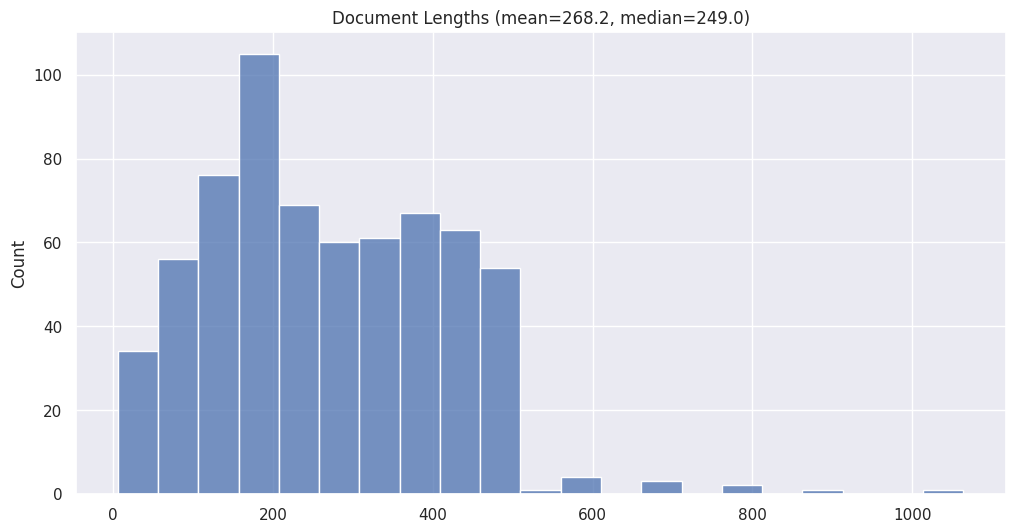

In [3]:
%matplotlib inline

import statistics
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme()

lengths = [len(doc.page_content) for doc in documents]

plt.figure(figsize=(12, 6))
sns.histplot(lengths)
plt.title(f"Document Lengths (mean={statistics.mean(lengths):.1f}, median={statistics.median(lengths):.1f})")
plt.show()

In [4]:
def compute_similarities(benchmark, documents):
    # Load model
    model = SentenceTransformer(
        "Qwen/Qwen3-Embedding-8B",
        model_kwargs={"quantization_config": BitsAndBytesConfig(load_in_8bit=True)}
    )
    # Compute embeddings
    document_embeddings = model.encode(
        [f"{document.metadata["source_file"]}: {document.page_content}" for document in documents],
        show_progress_bar=True,
    )
    query_embeddings = model.encode(
        [test['query'] for test in benchmark],
        prompt_name="query",
        show_progress_bar=True,
    )
    # Compute similarity
    similarities = model.similarity(query_embeddings, document_embeddings)
    # Cleanup
    del model
    cleanup()

    return similarities

similarities = compute_similarities(benchmark, documents)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
import torch

from lib.metrics import print_evaluations


ranks = torch.argsort(similarities, descending=True)

print("Baseline Evaluation")
print_evaluations(benchmark, documents, ranks)

Baseline Evaluation
precision @ 1 :  0.2625, recall @ 1 :  0.1365
precision @ 2 :  0.2262, recall @ 2 :  0.1962
precision @ 4 :  0.2017, recall @ 4 :  0.2896
precision @ 8 :  0.1595, recall @ 8 :  0.4436
precision @ 16:  0.1175, recall @ 16:  0.5895
precision @ 32:  0.0829, recall @ 32:  0.7562
precision @ 64:  0.0556, recall @ 64:  0.9084
AUC: 0.09514446846187427


In [6]:
from tqdm.notebook import tqdm
import torch

from lib.rerank import Reranker


model_path = "ContextualAI/ctxl-rerank-v2-instruct-multilingual-2b"
TOP_K = 64

def rerank(benchmark, documents, ranks, model_path=model_path, topk=TOP_K):
    reranker = Reranker(model_path)
    
    results = []
    for idx, (test, doc_idxs) in tqdm(
        enumerate(zip(benchmark, ranks)),
        total=min(len(benchmark), len(ranks))
    ):
        result = reranker(
            query=benchmark[idx]['query'],
            instruction='',
            documents=[
                f"{documents[document_idx].metadata["source_file"]}: {documents[document_idx].page_content}" 
                for document_idx in ranks[idx, :TOP_K]
            ],
        )
        results.append(result)
    
        if idx % 8 == 0:
            cleanup()
    
    reranks = []
    for idx, result in enumerate(results):
        top_documents = ranks[idx, :TOP_K]
        base_document_idxs = [int(top_documents[relative_idx]) for score, relative_idx, content in result]
        reranks.append(base_document_idxs)
    return reranks

ranks = torch.argsort(similarities, descending=True)
reranks = rerank(benchmark, documents, ranks)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

/home/joshuachin/miniconda3/envs/RAG-2/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [7]:
print(f"Reranked (K={TOP_K}) Evaluation")
print_evaluations(benchmark, documents, reranks)

Reranked (K=64) Evaluation
precision @ 1 :  0.3622, recall @ 1 :  0.1945
precision @ 2 :  0.2997, recall @ 2 :  0.2698
precision @ 4 :  0.2439, recall @ 4 :  0.3708
precision @ 8 :  0.1834, recall @ 8 :  0.5037
precision @ 16:  0.1316, recall @ 16:  0.6676
precision @ 32:  0.0861, recall @ 32:  0.8013
precision @ 64:  0.0556, recall @ 64:  0.9084
AUC: 0.14864552009354637
